In [38]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tqdm
import random

# Model Libraries~from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV # Sort out as we go along
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, log_loss, roc_auc_score, balanced_accuracy_score, \
                                                        roc_auc_score, f1_score # Sort out as we go along
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Set random state for reproducability
random_state = 81


## Problem Statement

- Our problem statement is to predict whether a country will declare bankruptcy the following year (1) or not (0)
- As with all binary classification problems, we will need to be wary of Type 1 (false negative) or Type 2 (false positive) errors.
- Depending on how this model will be used, we must consider acceptable levels of each of these errors while trying to maximise the performance of correctly predicting bankruptcy.
- Given my assumed brief that this model will be used by a bank to help identify companies that need extra support in the future.

### Dataset Information
- The dataset I am using is pubically available here: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction but some amendments have been made. Mainly adding in some issues that need to be identified and cleaned and adding in a categorical variable.

## Data Health Check

In [2]:
df = pd.read_csv('../../GitHub/Credit-Bankruptcy-Prediction/bankruptcy_prediction_learning.csv')

In [3]:
print(df.shape)
df.head(2)

(6778, 97)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Company Type
0,1,0.370594,0.424389,0.40575,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646434,...,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,LLP
1,1,0.464291,0.538214,0.51673,0.610235,0.610235,0.998946,0.797380,0.809301,0.30355643,...,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,LLP


In [4]:
# Clean up column names, that have inherited blank spaces
#df.columns[0:2]
col_names = dict(zip(df.columns,[column_name.strip().replace(' ','_') for column_name in df.columns]))
col_names['Bankrupt?'] = 'Bankrupt'
df.rename(columns = col_names, inplace = True)

In [5]:
# Check the dtypes of our data
print(Counter(df.dtypes))

# Most of our data seems to be float64 which was to be expected. 
# A few are int64 only, let us check that they are flags as they should be.
# There are a few Object types which we will need to look into more.

Counter({dtype('float64'): 91, dtype('int64'): 3, dtype('O'): 3})


In [6]:
# We can see that all our int64 columns are indeed binary flags
df.select_dtypes(include=['int64']).columns


Index(['Bankrupt', 'Liability-Assets_Flag', 'Net_Income_Flag'], dtype='object')

In [7]:
# We see that 2 of our columns that are objects should infact be floats
print(list(df.select_dtypes(include=['O']).columns))
df.select_dtypes(include=['O']).head()

['Non-industry_income_and_expenditure/revenue', 'Revenue_Per_Share_(Yuan_¥)', 'Company_Type']


,Non-industry_income_and_expenditure/revenue,Revenue_Per_Share_(Yuan_¥),Company_Type
0,0.302646434,0.01755978,LLP
1,0.30355643,0.021144335,LLP
2,0.302035177,0.005944008,LLP
3,0.303349536,0.014368468,LLP
4,0.303474978,0.029689792,Limited Company


In [8]:
# Change these to float
try: 
    df.loc[:,'Non-industry_income_and_expenditure/revenue'].astype(float)
except Exception as e:
    print(e)
# We can see that we have some text showing up in our columns that is unexpected and that we must clear

could not convert string to float: 'trap'


In [9]:
''' Function to take a column that is meant to be float, identify the entries that cannot be converted to float return NaN instead
         and change the column type to float.
Input: DataFrame, String or List (Dataframe Columns) | Output: DataFrame
'''
def clean_text_from_float_columns(input_dataframe, input_dataframe_columns):
    if isinstance(input_dataframe_columns, (str, list)):
        if isinstance(input_dataframe_columns, str):
            input_dataframe_columns = [input_dataframe_columns]
        for input_column_name in input_dataframe_columns:
            cleaned_column = []
            for value in input_dataframe.loc[:,input_column_name]:
                try:
                    cleaned_column.append(float(value))
                except Exception:
                    cleaned_column.append(np.NaN)
            input_dataframe.loc[:,input_column_name] = cleaned_column
            input_dataframe.loc[:,input_column_name].astype(float)
    else:
        print('Error, this function requires a column name or list of column names in the DataFrame')
    return input_dataframe

In [10]:
# After cleaning those columns we see that our dtpyes are as we would expect them
df = clean_text_from_float_columns(df, ['Non-industry_income_and_expenditure/revenue','Revenue_Per_Share_(Yuan_¥)'])
print(Counter(df.dtypes))

Counter({dtype('float64'): 93, dtype('int64'): 3, dtype('O'): 1})


C:\Users\mattp\AppData\Local\Temp\ipykernel_21888\3365451148.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  input_dataframe.loc[:,input_column_name] = cleaned_column


## Come back to this for being able to infer data if missing

In [11]:
# # Check which of our columns have missing data
cols_with_na = dict(df.isna().sum()[df.isna().sum() > 0])
print('There are {} data points with missing data ({} in total).'.format(len(cols_with_na),sum(cols_with_na.values())))

# # We could remove all records with na we lose 42 records, 2 of which are ones are bankruptcy records.
# # To show how we can fill missing data in, I'll infer those records for columns that have more than 2 missing data points
# cols_to_correct = [key for key, value in cols_with_na.items() if value >= 3]
# cols_to_correct

There are 28 data points with missing data (45 in total).


In [12]:
df = df.dropna()

In [13]:
# This dataset looks like its been normalised already but to double check
df.min()[df.min() != 0]

Net_Income_Flag      1
Company_Type       LLP
dtype: object

In [14]:
# However we can see that a lot of variables have not been normalised as their maximum is not 1.
df.max()[df.max() != 1] 

Operating_Expense_Rate                    9990000000.0
Research_and_development_expense_rate     9980000000.0
Interest-bearing_debt_interest_rate        990000000.0
Revenue_Per_Share_(Yuan_¥)                3020000000.0
Total_Asset_Growth_Rate                   9990000000.0
Net_Value_Growth_Rate                     9330000000.0
Current_Ratio                             2750000000.0
Quick_Ratio                               9230000000.0
Total_debt/Total_net_worth                9940000000.0
Accounts_Receivable_Turnover              9740000000.0
Average_Collection_Days                   9730000000.0
Inventory_Turnover_Rate_(times)           9990000000.0
Fixed_Assets_Turnover_Frequency           9990000000.0
Revenue_per_person                        8810000000.0
Allocation_rate_per_person                9570000000.0
Quick_Assets/Current_Liability            8820000000.0
Cash/Current_Liability                    9650000000.0
Inventory/Current_Liability               9910000000.0
Long-term_

In [15]:
# Find out how many outliers we have across our dataset
has_outliers = df.max()[df.max() != 1].index.to_list()
has_outliers.remove('Company_Type')
outlier_counts = dict(zip(has_outliers, [df[df[col_name] > 1].shape[0] for col_name in has_outliers]))
outlier_counts

{'Operating_Expense_Rate': 2258,
 'Research_and_development_expense_rate': 3993,
 'Interest-bearing_debt_interest_rate': 220,
 'Revenue_Per_Share_(Yuan_¥)': 5,
 'Total_Asset_Growth_Rate': 5942,
 'Net_Value_Growth_Rate': 2,
 'Current_Ratio': 1,
 'Quick_Ratio': 9,
 'Total_debt/Total_net_worth': 8,
 'Accounts_Receivable_Turnover': 22,
 'Average_Collection_Days': 18,
 'Inventory_Turnover_Rate_(times)': 2902,
 'Fixed_Assets_Turnover_Frequency': 1220,
 'Revenue_per_person': 2,
 'Allocation_rate_per_person': 12,
 'Quick_Assets/Current_Liability': 2,
 'Cash/Current_Liability': 43,
 'Inventory/Current_Liability': 97,
 'Long-term_Liability_to_Current_Assets': 107,
 'Current_Asset_Turnover_Rate': 1223,
 'Quick_Asset_Turnover_Rate': 2354,
 'Cash_Turnover_Rate': 4177,
 'Fixed_Assets_to_Assets': 1,
 'Total_assets_to_GNP_price': 20}

In [16]:
# Given we aren't able to trace this datasets journey, I will assume that everything with less than 5% outlier rate has been normalised.
# Therefore I'll replace those outliers with 1 and then normalise the other datapoints using a min max scaler so our scales are consistent
fixing_outliers = [key for key, value in outlier_counts.items() if value / df.shape[0] < 0.05]
for key_col in fixing_outliers:
    df.loc[df.loc[:, key_col] > 1, key_col] = 1
    del outlier_counts[key_col]

df.loc[:,list(outlier_counts.keys())] = MinMaxScaler().fit_transform(df.loc[:,list(outlier_counts.keys())])

# Check our process has worked as expected
df.max()[df.max() != 1]

Company_Type    Partnership
dtype: object

## Exploratory Data Analysis

In [17]:
# We can see that we have a lot of variables to use for modelling so there are various things we can do to reduce our dimensionality
print('There are {} variable that we have to use to build our models with'.format(df.shape[1] - 1))

There are 96 variable that we have to use to build our models with


In [18]:
''' Function to identify and remove highly correlated variables
Input: DataFrame, Float (Threshold of correlation) | Output: DataFrame
'''
def find_and_remove_correlated_variables(input_df, threshold):
    corr = input_df.corr().abs() # Get correlation of all variables
    corr_pairs = corr.unstack().sort_values().reset_index().rename(columns = {'level_0':'Var 1','level_1':'Var 2',0:'Correlation'}) # Get pairs
    corr_pairs = corr_pairs[corr_pairs['Var 1'] != corr_pairs['Var 2']] # Remove correlation between the same variables
    high_correlation = corr_pairs.loc[corr_pairs.loc[:,'Correlation'] >= threshold] # Flag high correlation variables for removal above the input threshold
    high_correlation.iloc[::2] # Only take every other row to avoid removing both correlated variables
    variables_to_remove = list(high_correlation.iloc[::2].loc[:,'Var 1'].unique()) # Collect variables for removal

    output_df = input_df.drop(columns = variables_to_remove)
    return output_df

In [19]:
# Apply our high correlation cleansing to dataset and review how many variables we still have left
# Correlation threshold set at 0.7
company_type_col = df.loc[:,'Company_Type'].copy()
df = find_and_remove_correlated_variables(df.drop(columns = ['Net_Income_Flag','Company_Type']), 0.7)
df.loc[:,'Company_Type'] = company_type_col
print('After removing correlated variables there are {} variable that we have to use to build our models with'.format(df.shape[1] - 1))

After removing correlated variables there are 55 variable that we have to use to build our models with


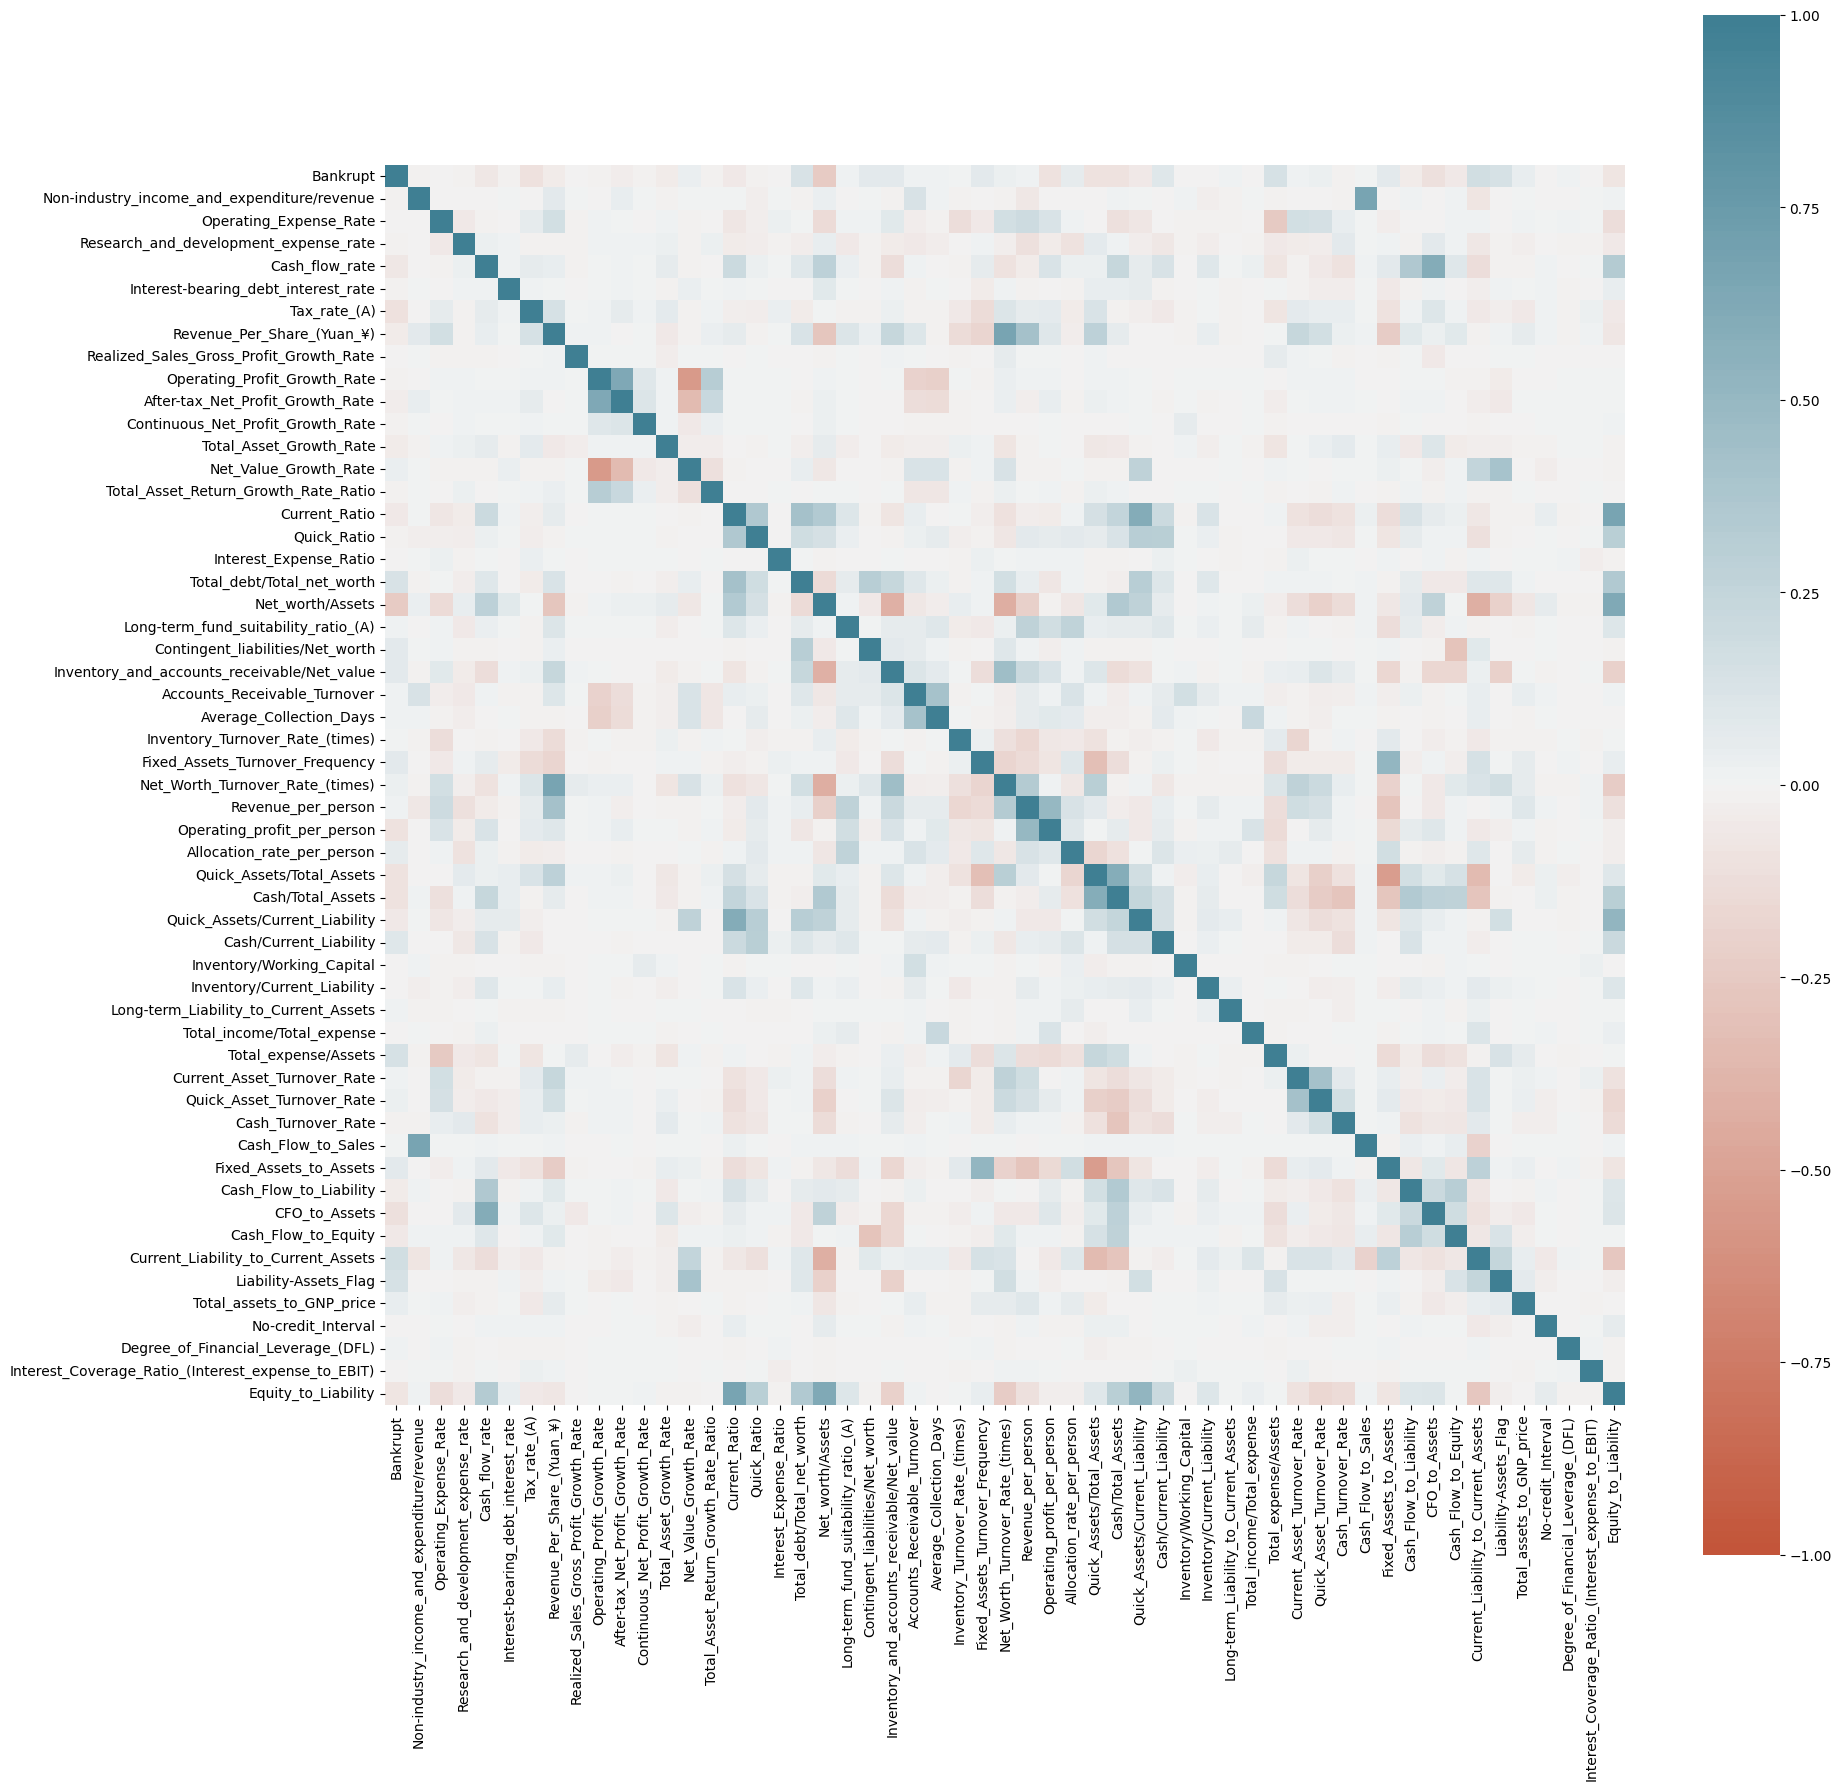

In [20]:
# Produce a graphic of correlation left within our variable set
# We can also see from the below chart that there are a few variables that bankruptcy seems to be more correlated to than others 
corr_vis = df.drop(columns = ['Company_Type']).corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(corr_vis, vmin = -1, vmax = 1, center = 0, cmap = sns.diverging_palette(20,220,n=200), square = True)

In [21]:
# As our company type has 3 values, we will need to use an encoder so that we can include it in our modelling.
# Given that our 'encoded' data is very similar, we'll use the inbuilt get_dummies function in pandas for our Company_Type variable
df_final = df.drop(columns=['Company_Type']).join(pd.get_dummies(df.loc[:,'Company_Type']).rename(columns={'Limited Company':'Limited_Company'}),
                    how = 'left')

### Summary 
55 variables + the 3 from encoding our company type is still a lot of variables. Depending on our model type we may want to reduce the number further, annd there are a few methods we could consider:
- **Input from an SMEs** - Get our SMEs to indicate what the most important financial metrics are (or which ones are expected to be less important based on knowledge). The drawback is that we may miss some variable that is thought to be insignificant but actually is a good indicator of bankruptcy (though we can see in the correlation matrix above that there is not a strong correlation between bankrupcty and any of our variables)
- **Forward / Backword Selection** - Train a model one variable at a time and find the variable that results in the best accuracy score. Then model that variable with all the remaning variables once at a time to see the increase in accuracy, recursively until there is little to no benefit in accuracy or vice versa for backward selection. This does not account for the impact of multiple other variables vs the contribution the single variable in each iteration so can result in lower quality models.
- **Principle Component Analysis** - Dimensionality reduction by producing 'principle components' constructed out of linear combinations of our current variables in such a way as to retain the variance of our linear variables. The drawback is that our principle components don't really have any meaning as they are a combination of many variables and only perform well on linear data. This may become an issue if the model is used to decide *whether lending should occur or not*, as we won't be able to provide much information about why the model has predicted bankruptcy.

Given that I am starting with a Random Forest solution, which can by design deal with larger amounts of input variables, I will not perform PCA at this stage (though I will rerun any tree based model with post PCA to check performance). **I will also only tune the solution to the dataset imbalance on the tree based solution, which will then be used for all the following models.**

## Modelling - Tree Based Solutions
### **Random Forest**
#### Overview
Our first model is a Random Forest. This means that for our dataset, we will create multiple decision trees and then aggregate the outcomes of all the decision trees to decide on the prediction for each of our cases. At each stage of making each branch any of sub decision trees, the model will pick a subset of variables to be considered, this means that the decision trees we are going to aggregate will actually be different.
#### Things to note with implementation
By default the sklearn RandomForestClassifier also bootstraps our data, this means that for each decision tree it creates, it also create a sub sample of variables associated with it, so now each of our decision trees has 2 layers of variable randomisation.
This randomisation ensures that our model does not overfit our test data, by forcing the use of a wider range of varibles within our loss function.
#### Loss Measure
We will be using Gini Impurity here. This means that at each branch in our decision trees we will aim to maximise Gini Gain = Gini Impurity (Target Var) - Gini Impurity (Any attribute within Subset). The Gini method involves looking at the liklihood of randomly assigning the correct target variable to cases for each subset of our dataset caused by the branching attribute. 
#### Accuracy Measures
As accuracy is the most important thing about our model, we will consider a few different accuracy metrics. Note that for tree based models, the probability of predictions is based on the number of trees that return each outcome:
- Accuracy - Accuracy is the ratio of correct predictions over all predictions made.
- **Balanced Accuracy** - Simply an average of accuracy across each class (better metric for imbalanced datasets).
- Precision - Precision is the ratio of correct predictions over all positive predictions.
- Recall - Recall is the ratio of ratio of correct predictions over all samples that are actually positive.
- **F1 Score** - F1 Score is a weighted average of Precision & Recall (and therefore takes into account how accurately we predict the target correctly and how often we predict the target incorrectly).
- **Log Loss** - Log Loss measures the how far the probability of each prediction is compared to the true value and taking an average of those differences. The way the formula is constructed, the further away from the true value a probability the higher the score ends up being (lower score is better).
- **ROC AUC** - ROC AUC measures the distinction of the predictions along the probability scale. The closer to 1 the score is, the easier it is to create a threshold of probability that indicates the true value for a sample is either of our target classification variables.


In [39]:
# Define function to get our scoring results for each model:
def accuracy_scores(y_true, y_pred, y_pred_probs):
    print('Balanced Accuracy Score: {}'.format(round(balanced_accuracy_score(y_true, y_pred), 3)))
    print('Log Loss score: {}'.format(round(log_loss(y_true, y_pred_probs), 3)))
    print('ROC AUC score: {}'.format(round(roc_auc_score(y_true, y_pred_probs), 3)))
    print('F1 Macro score: {}'.format(round(f1_score(y_true, y_pred, average = 'macro'), 3)))
    print(classification_report(y_true, y_pred))
    fig, ax = plt.subplots(figsize=(5, 3))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax = ax)


In [23]:
# Prepare out dataset for training
X_train, X_test, y_train, y_test = train_test_split(df_final.drop(columns=['Bankrupt']), 
                                                    df_final.loc[:,'Bankrupt'], 
                                                    test_size = 0.2, 
                                                    random_state = 85) # Random state picked to get a consistent target variable split
print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print(r'Train target class split: {}% Bankrupt'.format(round(100 * y_train.sum()/X_train.shape[0],3)))
print(r'Test target class split: {}% Bankrupt'.format(round(100 * y_test.sum()/X_test.shape[0],3)))

X_train size: (5388, 57)
X_test size: (1348, 57)
y_train size: (5388,)
y_test size: (1348,)
Train target class split: 3.081% Bankrupt
Test target class split: 3.042% Bankrupt


In [24]:
model_rf = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    max_depth = 5, # We may consider deeper trees later on during this process
    bootstrap = True, # To help reduce overfitting on a dataset that might have a lot of noise
    max_features = 'sqrt', # For our dataset this is 7, so for every branch 7 variables will be chosen at randomm for consideration
    random_state = random_state
)

In [30]:
# Fit model to train data and make predictions on test data
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
y_pred_prob = model_rf.predict_proba(X_test)
y_pred_prob = pd.DataFrame(y_pred_prob)[1]

Balanced Accuracy Score: 0.548
Log Loss score: 0.084
ROC AUC score: 0.94
F1 Macro score: 0.576
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1307
           1       0.57      0.10      0.17        41

    accuracy                           0.97      1348
   macro avg       0.77      0.55      0.58      1348
weighted avg       0.96      0.97      0.96      1348



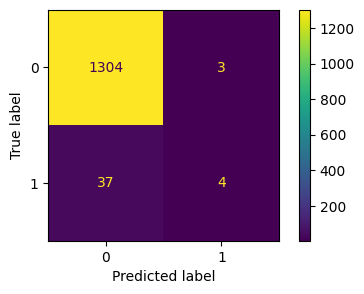

In [40]:
# View the some statistics on accuracy 
accuracy_scores(y_test, y_pred_rf, y_pred_prob)

As expected the model performs very badly on our original data due to a large imbalance on our target variable to non-bankruptcy. To overcome this problem we could look at a few methods:
- Undersampling - Take a subset of our data where equate the number of bankruptcy / non-banktruptcy samples. This however will remove over 95% of non-bankruptcy cases and is unlikely to resemble the actual world.
- Oversampling - Duplicate minority entries / provide a higher weighting to minority class samples. This can cause the model to overfit on patterns that emerge within our entries relating to bankruptcy, that may not hold well for test samples
- Synthetic Minority Oversampling Technique (SMOTE) - Take samples from the minority class and create new minority class samples using k-nearest neighbours between two minority samples. By creating new minority samples we have more information for the model to capture, however we must exercise restraint to avoid creating too much synthetic data that also does not reflect the real world.

I will be using this model to fine tune a SMOTE solution.

#### SMOTE 50%

In [32]:
smote_object = SMOTE(sampling_strategy = 0.5, random_state = random_state)
model_rf_smote_50 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 5, bootstrap = True, max_features = 'sqrt', random_state = random_state)

In [36]:
X_50_sample, y_50_sample = smote_object.fit_resample(X_train, y_train)
model_rf_smote_50.fit(X_50_sample, y_50_sample)
y_pred_50 = model_rf_smote_50.predict(X_test)
y_pred_50_prob = model_rf_smote_50.predict_proba(X_test)
y_pred_50_prob = pd.DataFrame(y_pred_50_prob)[1]

Balanced Accuracy Score: 0.824
Log Loss score: 0.183
ROC AUC score: 0.939
F1 Macro score: 0.68
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1307
           1       0.27      0.71      0.39        41

    accuracy                           0.93      1348
   macro avg       0.63      0.82      0.68      1348
weighted avg       0.97      0.93      0.95      1348



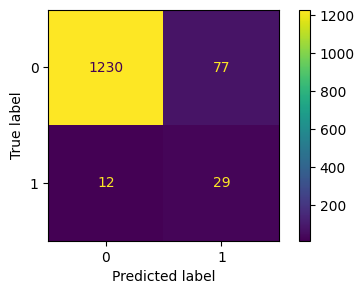

In [41]:
# View the some statistics on accuracy 
accuracy_scores(y_test, y_pred_50, y_pred_50_prob)

We can see that we have much better recall using this split, but have decreased the precision. Overall the F1 score is much better for this model. Lets try reducing the SMOTE sample to see if we can improve precision in our model.
#### SMOTE 20%

In [42]:
smote_object = SMOTE(sampling_strategy = 0.2, random_state = random_state)
model_rf_smote_20 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 5, bootstrap = True, max_features = 'sqrt', random_state = random_state)

In [43]:
X_20_sample, y_20_sample = smote_object.fit_resample(X_train, y_train)
model_rf_smote_20.fit(X_20_sample, y_20_sample)
y_pred_20 = model_rf_smote_20.predict(X_test)
y_pred_20_prob = model_rf_smote_20.predict_proba(X_test)
y_pred_20_prob = pd.DataFrame(y_pred_20_prob)[1]

Balanced Accuracy Score: 0.79
Log Loss score: 0.123
ROC AUC score: 0.944
F1 Macro score: 0.725
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1307
           1       0.38      0.61      0.47        41

    accuracy                           0.96      1348
   macro avg       0.69      0.79      0.73      1348
weighted avg       0.97      0.96      0.96      1348



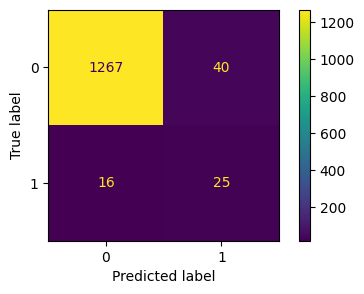

In [44]:
# View the some statistics on accuracy 
accuracy_scores(y_test, y_pred_20, y_pred_20_prob)

In [48]:
# 20% SMOTE seems to the sweet spot for oversampling. This is based on how the F1 score for our model is much higher than the original 
# imbalanced dataset and the F1 & ROC are higher and log-loss lower than under the 50% SMOTE.
# For simplification I will now replace the training data with our 20% smote training data
del model_rf_smote_20, model_rf_smote_50
X_train = X_20_sample
y_train = y_20_sample

### Back to the Random Forest Modeling